<h1 align=center><font color=blue>Titanic: Predicting Survival</font></h1>

<h2><font color=blue> Environmental Setup </font></h2>

In [1]:
# import necessary packages
import logging
logging.basicConfig(format='%(process)d-%(levelname)s-%(message)s')
import warnings

import numpy as np
from scipy.stats import expon
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%matplotlib inline

<h2><font color=blue> Exploratory Data Analysis & Feature Engineering </font></h2>

In [2]:
train = pd.read_csv("train.csv")
print(f"The train dataset contains {train.shape[0]} rows and {train.shape[1]} columns")
train.head(3)

The train dataset contains 891 rows and 12 columns


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
test = pd.read_csv("test.csv")
print(f"The test dataset contains {test.shape[0]} rows and {test.shape[1]} columns")
test.head(3)

The test dataset contains 418 rows and 11 columns


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


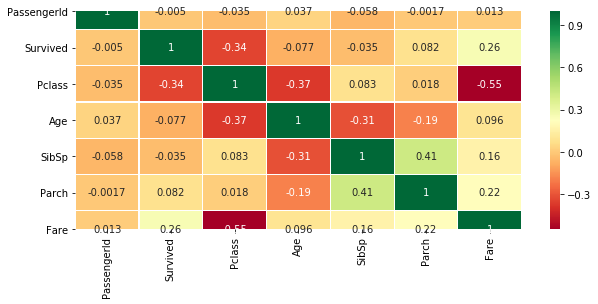

In [6]:
# numeric train columns

train_num_cols = list(train.describe().drop('PassengerId', axis=1).columns)
sns.heatmap(train.corr(), annot=True, cmap='RdYlGn', square=False, linewidths=0.1)
f = plt.gcf()
f.set_size_inches(10, 4)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


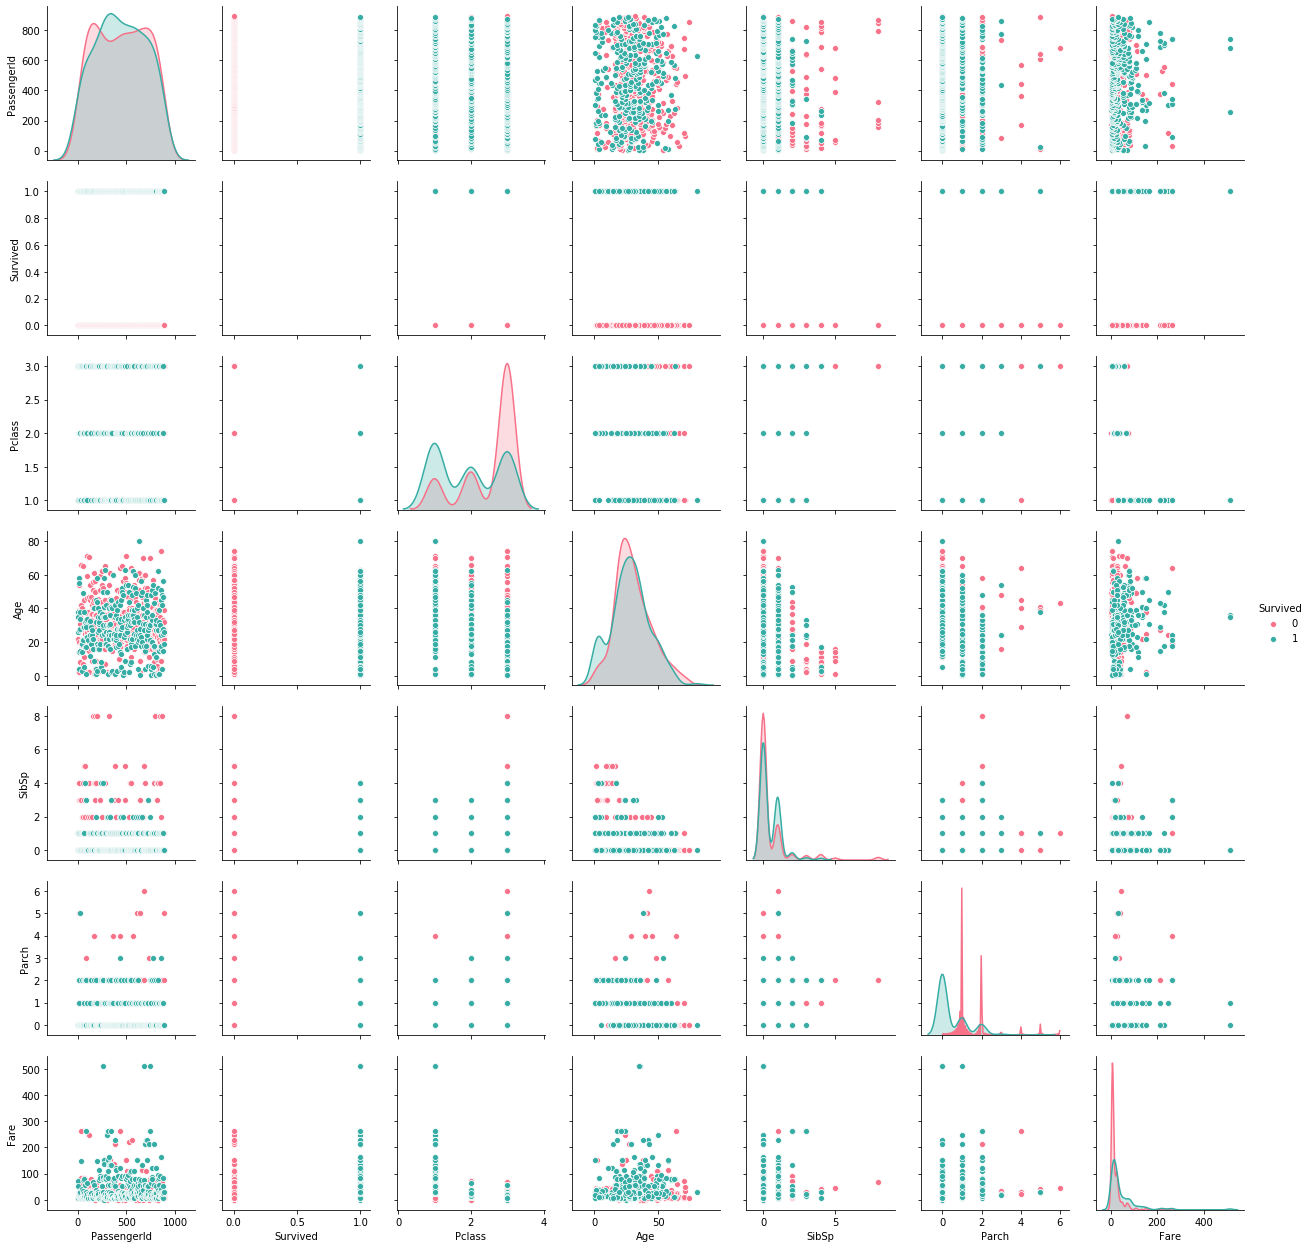

In [7]:
sns.pairplot(train, hue='Survived', palette="husl")

Exploring the data at first glance shows the *Pclass* and *Fare* appear to have some predicting power as to whether a passenger survives or not. However, looking at the raw numeric features alone cannot give us that much information. Thus there is need for further feature engineering and data exploration.

In [8]:
def age_feature(df, feature):
    
    age_bins = [0,7,17,40,60,100]
    labels = ['kids','child', 'Adult', 'Elderly', 'Senior']
    df[feature] = df[feature].fillna(df[feature].mean())
    df[feature+'_'+'Category'] = pd.cut(df[feature], 
                                          bins=[0,7,17,40,60,100], 
                                          labels=['kids','child', 'Adult', 'Elderly', 'Senior'])
    df = df.drop(feature, axis=1)
    return df



def family_total_feature(df, sib_feat, parch_feat):
    
    df['FamilyTotal'] = df[sib_feat] + df[parch_feat] + 1
    # drop the sib and parch features
    df.drop([sib_feat, parch_feat], axis=1, inplace=True)
    return df

train_v1 = train.copy()
test_v1 = test.copy()
train_v1 = age_feature(train_v1, 'Age')
test_v1 = age_feature(test_v1, 'Age')
train_v1 = family_total_feature(train_v1, 'SibSp', 'Parch')
test_v1 = family_total_feature(test_v1, 'SibSp', 'Parch')

train_v1.head()

,PassengerId,Survived,Pclass,Name,Sex,Ticket,Fare,Cabin,Embarked,Age_Category,FamilyTotal
0,1,0,3,"Braund, Mr. Owen Harris",male,A/5 21171,7.2500,NaN,S,Adult,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,71.2833,C85,C,Adult,2
2,3,1,3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,7.9250,NaN,S,Adult,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,53.1000,C123,S,Adult,2
4,5,0,3,"Allen, Mr. William Henry",male,373450,8.0500,NaN,S,Adult,1


In [9]:
train_v1 = pd.get_dummies(train_v1, columns=['Sex', 'Age_Category', 'Embarked', 'Pclass'],
                         prefix = ['Sex', 'Age_cat', 'Emb', 'Pclass'])
test_v1 = pd.get_dummies(test_v1, columns=['Sex', 'Age_Category', 'Embarked', 'Pclass'],
                         prefix = ['Sex', 'Age_cat', 'Emb', 'Pclass'])

# drop the Name, cabin, ticket features
train_v1.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_v1.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

train_v1.head(3)

,Survived,Fare,FamilyTotal,Sex_female,Sex_male,Age_cat_kids,Age_cat_child,Age_cat_Adult,Age_cat_Elderly,Age_cat_Senior,Emb_C,Emb_Q,Emb_S,Pclass_1,Pclass_2,Pclass_3
0,0,7.2500,2,0,1,0,0,1,0,0,0,0,1,0,0,1
1,1,71.2833,2,1,0,0,0,1,0,0,1,0,0,1,0,0
2,1,7.9250,1,1,0,0,0,1,0,0,0,0,1,0,0,1


In [10]:
train_v1['FamilyTotal'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilyTotal, dtype: int64

In [11]:
test_v1.head()

,Fare,FamilyTotal,Sex_female,Sex_male,Age_cat_kids,Age_cat_child,Age_cat_Adult,Age_cat_Elderly,Age_cat_Senior,Emb_C,Emb_Q,Emb_S,Pclass_1,Pclass_2,Pclass_3
0,7.8292,1,0,1,0,0,1,0,0,0,1,0,0,0,1
1,7.0000,2,1,0,0,0,0,1,0,0,0,1,0,0,1
2,9.6875,1,0,1,0,0,0,0,1,0,1,0,0,1,0
3,8.6625,1,0,1,0,0,1,0,0,0,0,1,0,0,1
4,12.2875,3,1,0,0,0,1,0,0,0,0,1,0,0,1


<h2><font color=blue> Modelling </font></h2>

In [12]:
# silent warnings
warnings.filterwarnings(action='ignore')

# split train and test data
X_train = train_v1.drop('Survived', axis=1)
y_train = train_v1['Survived']

# estimators

estimators = [('LR', LogisticRegression()), ('DTC', DecisionTreeClassifier()),
             ('SVM', SVC()), ('RFC', RandomForestClassifier()),
             ('KNN', KNeighborsClassifier()), ('GNB', GaussianNB())]

for estimator in estimators:
    steps = [('scaler', StandardScaler()), estimator]
    model = Pipeline(steps)
    # evaluate pipeline
    seed = 101
    kfold = KFold(n_splits=10, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    mean_score = scores.mean()
    print(f"{estimator[0]} {mean_score}\n")

LR 0.8137203495630463

DTC 0.8025343320848938

SVM 0.8294257178526842

RFC 0.8036579275905119

KNN 0.8171285892634206

GNB 0.7935955056179774



<h2><font color=blue> Hyperparameter Tunning </font></h2>

In [13]:
SVC().get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

param_grid = [
    {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'linear']}]

search = GridSearchCV(estimator=SVC(), 
                      param_grid=param_grid, cv=6).fit(X_train_scaled, y_train)

print(search.best_score_)
print(search.best_params_)

0.8316498316498316
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


<h2><font color=blue> Parameter Tunning </font></h2>

In [56]:
train_v2 = train_v1.copy()
fare_bins = [0, 50, 200, 700]
labels = ['low_fare', 'medium_fare', 'high_fare']
train_v2['Fare_Class'] = pd.cut(train_v2['Fare'],
                               bins=fare_bins,
                               labels=labels)
train_v2 = pd.get_dummies(train_v2, columns=['Fare_Class'])
train_v2.drop('Fare', axis=1, inplace=True)
train_v2.head(3)

,Survived,FamilyTotal,Sex_female,Sex_male,Age_cat_kids,Age_cat_child,Age_cat_Adult,Age_cat_Elderly,Age_cat_Senior,Emb_C,Emb_Q,Emb_S,Pclass_1,Pclass_2,Pclass_3,Fare_Class_low_fare,Fare_Class_medium_fare,Fare_Class_high_fare
0,0,2,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0
1,1,2,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0
2,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0


In [103]:
emb = train.groupby(
    ['Embarked', 'Sex', 'Survived']
    ).count()['PassengerId'].reset_index().rename(
    {'PassengerId':'Count'}, axis=1)
emb

,Embarked,Sex,Survived,Count
0,C,female,0,9
1,C,female,1,64
2,C,male,0,66
3,C,male,1,29
4,Q,female,0,9
5,Q,female,1,27
6,Q,male,0,38
7,Q,male,1,3
8,S,female,0,63
9,S,female,1,140


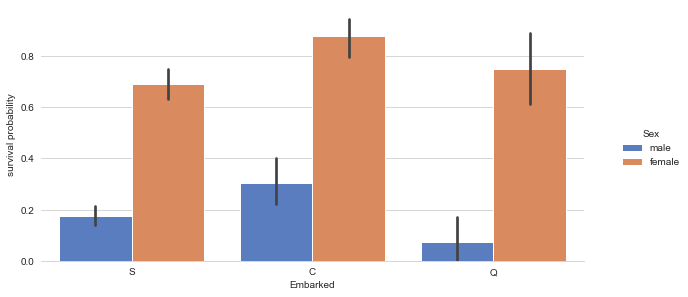

In [109]:
sns.set_style('whitegrid')
g = sns.catplot(x="Embarked", y="Survived", hue="Sex", data=train,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")
f=plt.gcf()
f.set_size_inches(10, 4)